In [1]:
import cv2
import numpy as np
import theano
import theano.tensor as tensor
import lasagne
import matplotlib.pyplot as plt
import os
from lasagne.layers import (Conv2DLayer, DropoutLayer, batch_norm, ReshapeLayer, InputLayer,
                            DenseLayer, NonlinearityLayer,ElemwiseSumLayer, MergeLayer,
                            TransformerLayer, MergeLayer, Layer, Gate)
from lasagne.nonlinearities import softmax, sigmoid, rectify, tanh, identity

from IPython.display import display, Image as im
from PIL import Image
from theano.tensor.nnet.abstract_conv import bilinear_upsampling
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

from lasagne.layers.dense import NINLayer
from lasagne.layers.pool import GlobalPoolLayer
from lasagne.layers import SliceLayer, TransformerLayer, PadLayer, ElemwiseSumLayer, ConcatLayer
from lasagne.utils import as_tuple
from lasagne.objectives import squared_error

lr = lasagne.nonlinearities.LeakyRectify(leakiness=0.2)
rect = lasagne.nonlinearities.rectify


/home/akshat/anaconda2/envs/ramana-test/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Preallocating 10613/11172 Mb (0.950000) on cuda2
Mapped name None to device cuda2: GeForce GTX 1080 Ti (0000:82:00.0)


In [2]:
# `get_conv_2d_filter` method is used from Kundan's implementation of masking. 


def uniform(stdev, size):
    """uniform distribution with the given stdev and size"""
    return np.random.uniform(low=-stdev * np.sqrt(3), high=stdev * np.sqrt(3),
                                size=size).astype(theano.config.floatX)

def get_conv_2d_filter(filter_shape, param_list = None, masktype = None, name = ""):
    fan_in = np.prod(filter_shape[1:])
    fan_out = (filter_shape[0] * np.prod(filter_shape[2:]))
    w_std = np.sqrt(2.0 / (fan_in + fan_out))
    filter_init = uniform(w_std, filter_shape)
    
    if masktype is not None:
        filter_init *= np.sqrt(2.).astype('float32')
    conv_filter = theano.shared(filter_init, name = name)
    param_list.append(conv_filter)
    if masktype is not None:
        mask = np.ones(filter_shape,
                          dtype=theano.config.floatX)
        for i in range(filter_shape[2]):
            for j in range(filter_shape[3]):
                if i > filter_shape[2]//2:
                    mask[:,:,i,j] = np.float32(0.0)
                if i == filter_shape[2]//2 and j > filter_shape[3]//2:
                    mask[:,:,i,j] = np.float32(0.0)
        if masktype == 'a':
            mask[:,:,filter_shape[2]//2,filter_shape[3]//2] = np.float32(0.0)
        conv_filter = conv_filter * mask
    return conv_filter


In [ ]:
from lasagne.nonlinearities import identity as linear
from lasagne.updates import adam
from lasagne.init import Uniform
# Heuristics
n_layers = 16
im_dims = 32
default_activation = 'relu'
n_filters = 40

# Hyper Params
batch_size = 20

learning_rate = tensor.fscalar('learning_rate')
filt_size = 7
 
#Build Model
layer_d = {}
input_im = tensor.tensor4()
reference_image = tensor.itensor4()
inp = InputLayer((batch_size, 3, 32, 32), input_var=input_im)

# First element in stack is horizontal output
# For the first two W is in range (0.05)
w1 = Uniform(range=0.05)
layer_d['in_v'] = batch_norm(Conv2DLayer(inp, n_filters, filter_size=((filt_size // 2) + 1, filt_size),
                              pad=(filt_size // 2 + 1, filt_size // 2), W=Uniform(0.06), nonlinearity=linear))
 
layer_d['v_to_h'] = ConcatLayer([SliceLayer(layer_d['in_v'],
                                 indices=slice(None, -(filt_size//2)-2), axis=2), inp])
hin_shape = layer_d['v_to_h'].output_shape

# Horizontal stack
layer_d['out_h'] = batch_norm(Conv2DLayer(layer_d['v_to_h'], n_filters, filter_size=(1,7), pad=(0,7//2),
                               W=get_conv_2d_filter((n_filters, hin_shape[1], 1, 7),
                                                     param_list=[], masktype='a'), nonlinearity=linear))
 
layer_d['out_v'] = SliceLayer(layer_d['in_v'], indices=slice(1, -(filt_size//2) - 1), axis=2)
# Loop variables
loop_v = layer_d['out_v']
loop_h = layer_d['out_h']

# update filter size and weight range
# The stack of convs after the initial would have a lower receptive field
filt_size = 3

for i in range( n_layers - 2):
    in_v = batch_norm(Conv2DLayer(loop_v, n_filters, filter_size=((filt_size // 2) + 1, filt_size),
                       pad=(filt_size // 2 + 1, filt_size // 2), W=Uniform(0.2), nonlinearity=linear))
 
    v_to_h = ConcatLayer([SliceLayer(batch_norm(Conv2DLayer(in_v, n_filters, filter_size=(1, 1),
                                                 pad='valid', W=Uniform(0.3), nonlinearity=linear)),
                                     indices=slice(None, -(filt_size//2)-2), axis=2),
                          loop_h])
    
    out_h_inshape = v_to_h.output_shape
    out_h = batch_norm(Conv2DLayer(v_to_h, n_filters, filter_size=(1, (filt_size // 2) + 1),
                                   pad=(0, filt_size // 2),
                                   W=get_conv_2d_filter((n_filters, out_h_inshape[1], 1, (filt_size // 2) + 1),
                                                        param_list=[], masktype='a')))
   
    h_to_h = batch_norm(Conv2DLayer(out_h, n_filters, filter_size=(1, 1), pad='valid', W=Uniform(0.3)))
 
    # Update the loop layer variable
    loop_v = NonlinearityLayer(SliceLayer(in_v, indices=slice(1, -(filt_size//2) - 1), axis=2))
 
    loop_h = ElemwiseSumLayer([SliceLayer(h_to_h, indices=slice(None, -(filt_size // 2)), axis=3),
                              loop_h])

layer_d['final_h']  = batch_norm(Conv2DLayer(loop_h, n_layers, filter_size=(1, 1), pad='valid',
                                             W=get_conv_2d_filter((n_filters, loop_h.output_shape[1], 1, 1 ),
                                                                  param_list=[], masktype='a')))
layer_d['final_v'] = Conv2DLayer(layer_d['final_h'], 3 * 256, filter_size = (1, 1), pad='valid', W=Uniform(0.3),
                                nonlinearity=linear)

pu_shape = layer_d['final_v'].output_shape
layer_d['out'] = ReshapeLayer(layer_d['final_v'], (pu_shape[0], pu_shape[1] // 256, pu_shape[2],
                                                   pu_shape[3], -1))
final_shape = layer_d['out'].output_shape

# Removing None from the shape
# Applying the 256 way softmax
layer_d['softmax_out'] = NonlinearityLayer(ReshapeLayer(layer_d['out'], (-1, 256)), nonlinearity=softmax)
final_out = ReshapeLayer(layer_d['softmax_out'], final_shape)

network_out = lasagne.layers.get_output(layer_d['softmax_out'])
network_param = lasagne.layers.get_all_params(layer_d['softmax_out'], trainable=True)

net_cost = lasagne.objectives.categorical_crossentropy(network_out, reference_image.flatten())
valid_cost = lasagne.objectives.categorical_crossentropy(lasagne.layers.get_output(layer_d['softmax_out'],
                                                                                   deterministic=True),
                                                        reference_image.flatten())
cost_grad = tensor.grad(net_cost.mean(), network_param)
updates = lasagne.updates.adam(cost_grad, network_param, learning_rate=learning_rate)

# Compile theano functions
mle_func = theano.function([input_im, reference_image, learning_rate], net_cost, updates=updates)
gen_func = theano.function([input_im], lasagne.layers.get_output(final_out, deterministic=True))
valid_func = theano.function([input_im, reference_image], valid_cost)
grad_func = theano.function([input_im, reference_image], cost_grad)

The cell below is for pre-processing and visualizing the CIFAR-10 dataset. We keep the image in the range of -1 to +1

Using Theano backend.


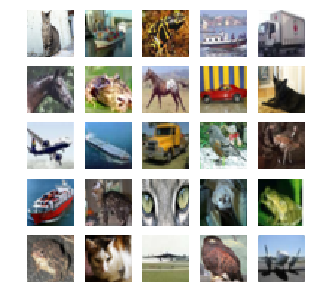

In [4]:
import cPickle
import tarfile
import pylab
import matplotlib.pyplot as plt

# dataset_path = './cifar-100-python/train'
    
# # path_to_zip_file = './cifar-100-python.tar.gz'
# # directory_to_extract_to = './'

# # zip_ref = tarfile.open(path_to_zip_file, 'r')
# # zip_ref.extractall(directory_to_extract_to)
# # zip_ref.close()

def downscale_images(X, LEVEL=255.0):
    X = X.astype('float32')/np.float32(LEVEL)
    return X

# def unpickle(file):
#     with open(file, 'rb') as fo:
#         dict = cPickle.load(fo)
#     return dict

# cifar_data = unpickle(dataset_path)


def normalise(im):
    im = im / np.float32(127.5) - np.float32(1.)
    return im

def denormalise(im, tanh=True):
    im = ((im + np.float32(1.0)) * np.float32(127.5)).astype(np.uint8)
    if tanh:
        im = im.transpose(0, 2, 3, 1)
    return im

%matplotlib inline

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

transposed_image = x_train.transpose(0, 2, 3, 1)

fig, axes1 = plt.subplots(5, 5, figsize=(5, 5))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(transposed_image[i:i+1][0])


The cell below is for pre-processing and visualizing the cropped 3 channel(RGB) BSDS dataset. 

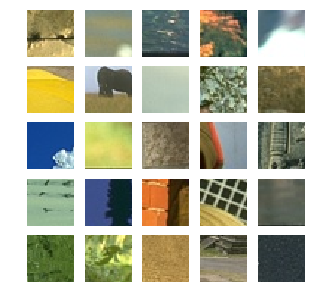

In [34]:
# Pre processing and visualisation for BSDS
data_path = '/media/data/akshat/cropped_ride/32_cropped_bsds.npz'
test_path = '/media/data/akshat/cropped_ride/32_test_bsds.npz'

up_train_images = dict(np.load(data_path))['arr_0']
up_test_images = dict(np.load(test_path))['arr_0'] 
x_train = up_train_images.transpose(0, 3, 2, 1)
x_test = up_test_images.transpose(0, 3, 2, 1)
fig, axes1 = plt.subplots(5, 5, figsize=(5, 5))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(up_train_images)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(up_train_images[i:i+1][0])


In [ ]:
def upscale_images(X, LEVEL):
    X = np.uint8(X*LEVEL)
    return X

x_test = x_test[np.random.randint(len(x_test), size=10000), :, :, :]

The below cell does the training and plotting of images once in N epochs. Optionally, the part of the below cell can be uncommented to check the norm of the gradient 

In [ ]:
import time
import scipy as sp
# test_loss = []
# gradients = []
# mean_grad = []
# mean_tloss = []
# mean_nll = []
generated_im = []
test_batch_n = int(round(len(x_test) / batch_size))
t_offset = 0
initial_lr = np.float32(4e-5)
batch_number = int(round(len(x_train) / batch_size))
for ep in range(100):
    valid_loss = 0
    # shuffled_inputs = train_image[np.random.randint(len(train_image), size=len(train_image)), :, :, :]
    offset = 0
    loss = 0
    cost_grad=0
    nll_loss = []
    begin = time.time()
    for num_iter, bn in enumerate(range(batch_number)):
        # Randomly shuffle inputs
        inputs = x_train[offset:offset + batch_size].astype('float32')
        reference_inps = upscale_images(x_train[offset:offset + batch_size], 255)
        loss = mle_func(inputs, reference_inps, initial_lr)
        nll_loss.append(loss)
        initial_lr = initial_lr * np.float32(0.9999995)
        offset += batch_size
#         if ep % 5 == 0:
#             cost_grad = np.max(np.asarray(grad_func(inputs, reference_inps)[-1]))
#             gradients.append(sp.stats.norm(cost_grad))

    end = time.time()
    print "LR is : " + str(initial_lr)
    mean_nll.append(np.mean(np.asarray(nll_loss)))
    print("NLL is " + str(mean_nll[-1]))
    print("Finished {} of {}. Time taken {:.3f}s".format(ep + 1, 1000,  end - begin))
    if ep % 5 == 0:
        test_loss = []
        for tep in range(test_batch_n):
            valid_loss = valid_func(x_test[t_offset:t_offset+batch_size].astype('float32'),
                                    upscale_images(x_test[t_offset:t_offset+batch_size], 255))
            test_loss.append(valid_loss)
        mean_tloss.append(np.mean(np.asarray(test_loss)))
        
        X = x_train[40:60, :, :, :].astype('float32')
        for i in range(32):
            for j in range(32):
                samples = np.argmax(gen_func(X), axis=4)
                out[:, :, i,j] = samples[:, :, i, j]
                X[:, :, i, j] = downscale_images(samples[:, :, i,j], 255)
        generated_im.append(X)

        print ("Mean Test loss at " + str(ep) + " is " + str(mean_tloss[-1]))
#         mean_grad.append(np.max(np.asarray(gradients)))
#         print("Grad at " + str(ep) + " is " + str(mean_grad[-1]))
#         gradients = []

In [ ]:
# generated_images = gen_func(np.zeros((100, 3, 32, 32)).astype('float32'))
# print np.argmax(generated_images, axis=4).shape
# samples = np.argmax(generated_images, axis=4).transpose(0, 2, 3, 1)

'''
This is stochastic sampling, sampling randomly from the 256 way softmax rather than sampling the best by using argmax
'''
rand_tindices = np.random.randint(len(x_test), size=32)
ran_geni = generated_im[6]
# out = np.zeros((20, 3, 32, 32)).astype('float32')
# for i in range(32):
#    for j in range(32):
#        samples = np.argmax(gen_func(ran_geni), axis=4)
#        out[:, :, i,j] = samples[:, :, i, j]
#        X[:, :, i, j] = downscale_images(samples[:, :, i,j], 255)


fig, axes1 = plt.subplots(5, 5, figsize=(5, 5))
# axes1.set_axis_off()
# axes1.imshow(reshaped_image[10])
# fig.imshow(reshaped_image[10])
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(ran_geni)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(ran_geni.transpose(0, 2, 3, 1)[i:i+1][0])

In [ ]:
# Saving the weights of the network
np.savez('bsds_weights.npz', *lasagne.layers.get_all_param_values(layer_d['softmax_out']))
print "Saved weights and grads"


In [ ]:
'''
Plot the loss curve
'''


# plt.plot(np.asarray(np.asarray(mean_grad)))
pla = np.asarray(mean_tloss, dtype='float32')
print pla.shape
plt.plot(pla)
print pla.shape